In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import sklearn.metrics as skm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
#subir tu archivo ACCIONES BOLSA ECUADOR.xlsx usando el siguiente código
uploaded = files.upload()


Saving ACCIONES BOLSA ECUADOR.xlsx to ACCIONES BOLSA ECUADOR.xlsx


In [3]:
data = pd.read_excel('ACCIONES BOLSA ECUADOR.xlsx')


In [4]:
print(data)


           FECHA                                   EMISOR     VALOR  \
0     2022-01-03                     BANCO GUAYAQUIL S.A.  ACCIONES   
1     2022-01-03  BANCO DE LA PRODUCCION S.A . PRODUBANCO  ACCIONES   
2     2022-01-03                     BANCO GUAYAQUIL S.A.  ACCIONES   
3     2022-01-03  BANCO DE LA PRODUCCION S.A . PRODUBANCO  ACCIONES   
4     2022-01-03                CORPORACION FAVORITA C.A.  ACCIONES   
...          ...                                      ...       ...   
17765 2024-06-14                BEVERAGE BRAND PATENTS SA  ACCIONES   
17766 2024-06-14                CORPORACION FAVORITA C.A.  ACCIONES   
17767 2024-06-14                CORPORACION FAVORITA C.A.  ACCIONES   
17768 2024-06-14                CORPORACION FAVORITA C.A.  ACCIONES   
17769 2024-06-14                CORPORACION FAVORITA C.A.  ACCIONES   

       VALOR NOMINAL  PRECIO  NUMERO ACCIONES  VALOR EFECTIVO PROCEDENCIA  
0                  1    0.99             3500         3465.00          

In [5]:
# 1.Filtrar el DataFrame para incluir solo las filas donde el emisor sea 'BANCO GUAYAQUIL S.A.'
data_filtered = data[data['EMISOR'] == 'BANCO GUAYAQUIL S.A.']

In [6]:

# 2. Convertir la columna de fechas al tipo de datos datetime
data_filtered['FECHA'] = pd.to_datetime(data_filtered['FECHA'])


<ipython-input-6-8cbda85bca5a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_filtered['FECHA'] = pd.to_datetime(data_filtered['FECHA'])


In [7]:
# Mostrar el tipo de datos de cada columna
print(data_filtered.dtypes)

FECHA              datetime64[ns]
EMISOR                     object
VALOR                      object
VALOR NOMINAL               int64
PRECIO                    float64
NUMERO ACCIONES             int64
VALOR EFECTIVO            float64
PROCEDENCIA                object
dtype: object


In [8]:
# 3.Verificar si hay valores nulos en el DataFrame filtrado
null_values = data_filtered.isnull().sum()
print(null_values)

FECHA              0
EMISOR             0
VALOR              0
VALOR NOMINAL      0
PRECIO             0
NUMERO ACCIONES    0
VALOR EFECTIVO     0
PROCEDENCIA        0
dtype: int64


In [9]:
# Obtener el tamaño de los datos
print("Tamaño de los datos:", data_filtered.shape)


Tamaño de los datos: (1183, 8)


In [10]:
# 4.Asegurarse de que los datos estén ordenados por fecha
data_filtered = data_filtered.sort_values(by='FECHA')


In [11]:
# 5. Seleccionar solo las columnas numéricas para el resampleo
data_filtered_numeric = data_filtered[['FECHA', 'PRECIO']]

In [12]:
# 6. Resamplear los datos a frecuencia mensual, tomando el promedio del precio
data_monthly = data_filtered_numeric.resample('M', on='FECHA').mean()

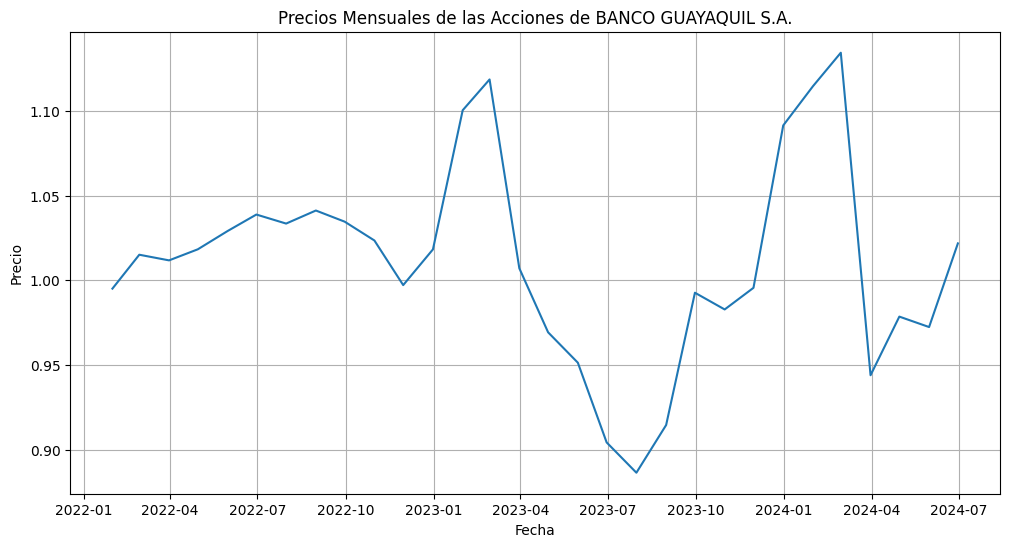

In [13]:
# 7. Visualizar la serie temporal de precios mensuales


plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index, data_monthly['PRECIO'])
plt.title('Precios Mensuales de las Acciones de BANCO GUAYAQUIL S.A.')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

In [14]:
# 8. Rellenar los valores faltantes con el último valor observado
data_monthly['PRECIO'] = data_monthly['PRECIO'].fillna(method='ffill')

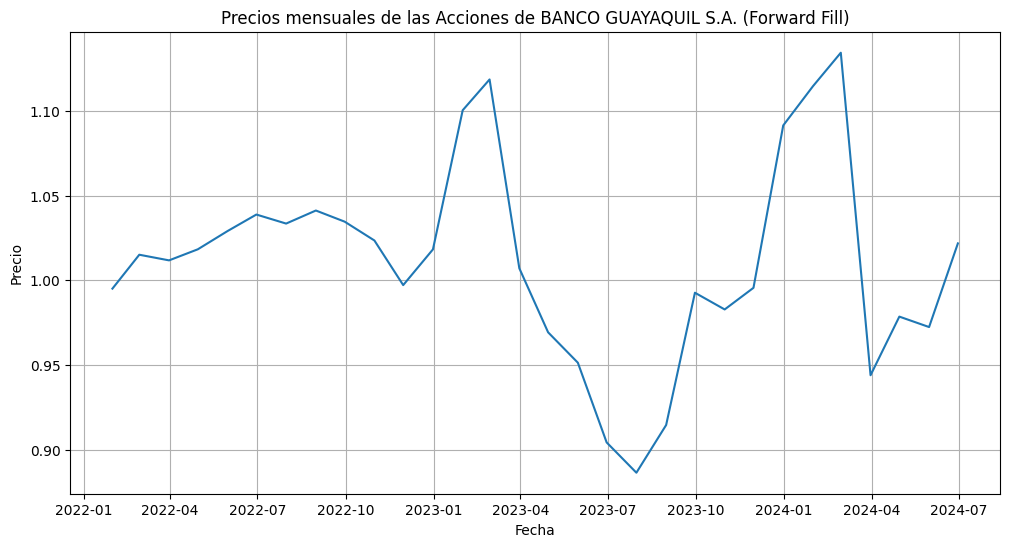

In [15]:
# 9.Visualizar la serie temporal de precios semanales después del relleno
plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index, data_monthly['PRECIO'])
plt.title('Precios mensuales de las Acciones de BANCO GUAYAQUIL S.A. (Forward Fill)')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

In [16]:
# 9. Descomposición de la serie temporal
result = seasonal_decompose(data_monthly['PRECIO'], model='additive', period=12)  # período mensual


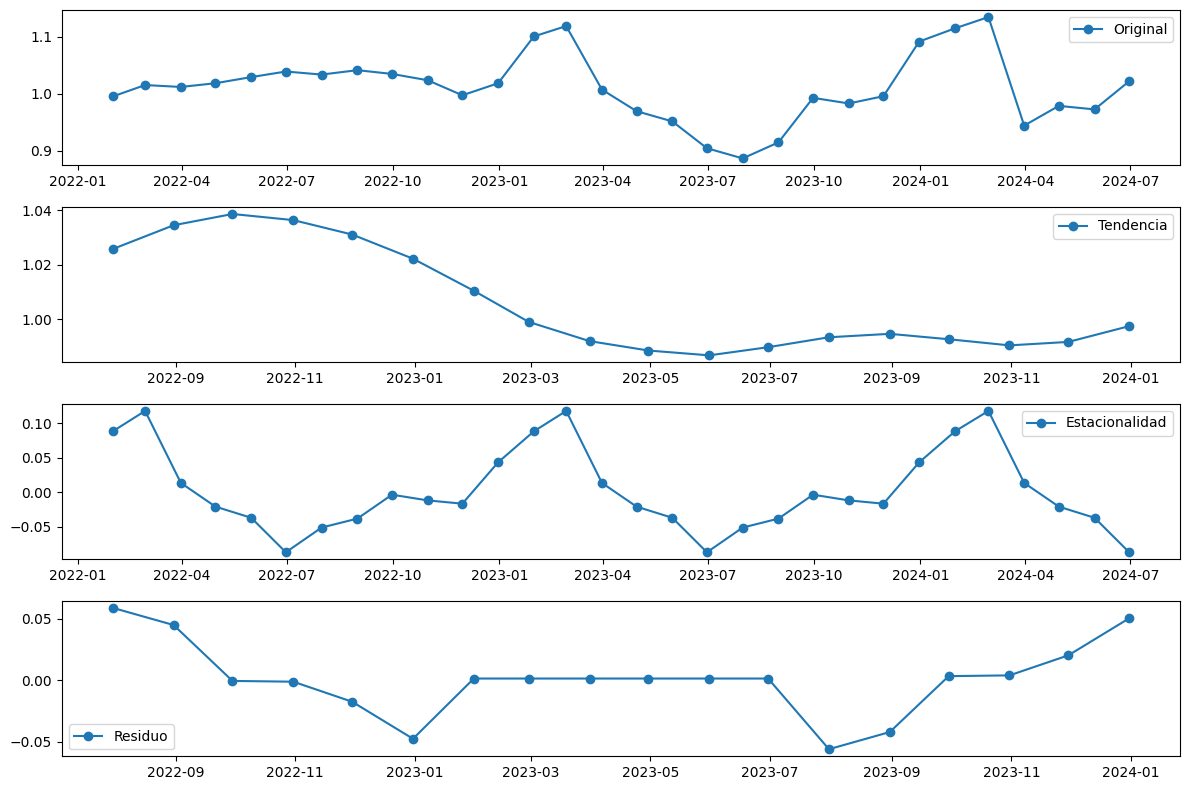

In [17]:
# 10.Visualización de las componentes
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(data_monthly['PRECIO'], label='Original', marker='o', linestyle='-')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(result.trend, label='Tendencia', marker='o', linestyle='-')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(result.seasonal, label='Estacionalidad', marker='o', linestyle='-')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(result.resid, label='Residuo', marker='o', linestyle='-')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

In [18]:
# 11. Prueba de estacionariedad
result = adfuller(data_monthly['PRECIO'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:')
for key, value in result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -2.5742160924558903
p-value: 0.09844422613338766
Critical Values:
	1%: -3.6790595944893187
	5%: -2.9678817237279103
	10%: -2.6231583472057074


In [20]:
# 12.Diferenciación para hacer la serie estacionaria
diff_data = data_monthly['PRECIO'].diff().dropna()

In [21]:
# 13.Realizar nuevamente la prueba ADF en la serie diferenciada
from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(diff_data)
print('ADF Statistic:', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -4.95030170413288
p-value: 2.7808529634411556e-05
Critical Values:
	1%: -3.6889256286443146
	5%: -2.9719894897959187
	10%: -2.6252957653061224


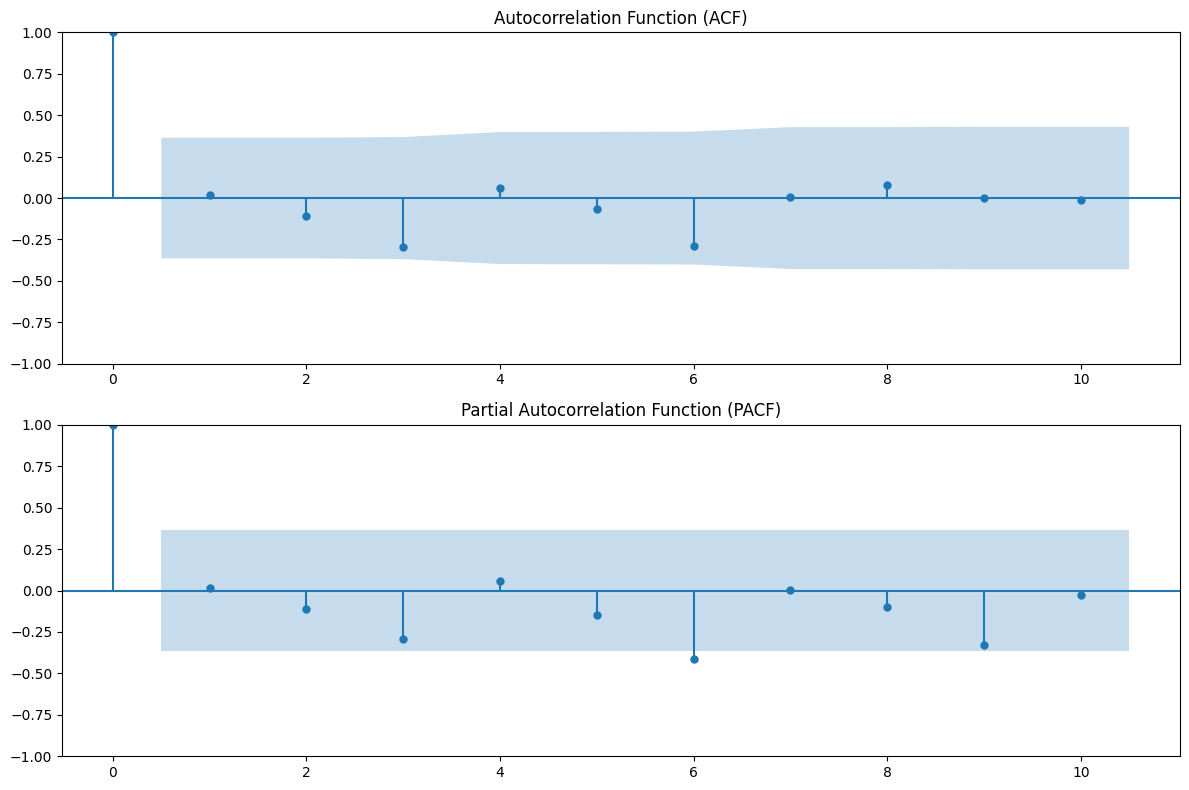

In [22]:
# 14. Gráficos ACF y PACF para denfinir p,d,q

num_lags = min(10, len(diff_data) // 2)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(diff_data, lags=num_lags, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

plot_pacf(diff_data, lags=num_lags, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [36]:
# 15. División de datos en entrenamiento y prueba
train_size = int(len(data_monthly) * 0.75)
train_data, test_data = data_monthly['PRECIO'][:train_size], data_monthly['PRECIO'][train_size:]

In [37]:
# 16.Ajuste del modelo con los datos de entrenamiento p,d,q
model = ARIMA(train_data, order=(1, 1, 1))
model_fit = model.fit()

In [38]:
# 17.Predicciones
predictions = model_fit.forecast(steps=len(test_data))

In [39]:
# 18. medir el error cuadratico
mse = mean_squared_error(test_data, predictions)
print(f'MSE: {mse}')

MSE: 0.00950697407417465


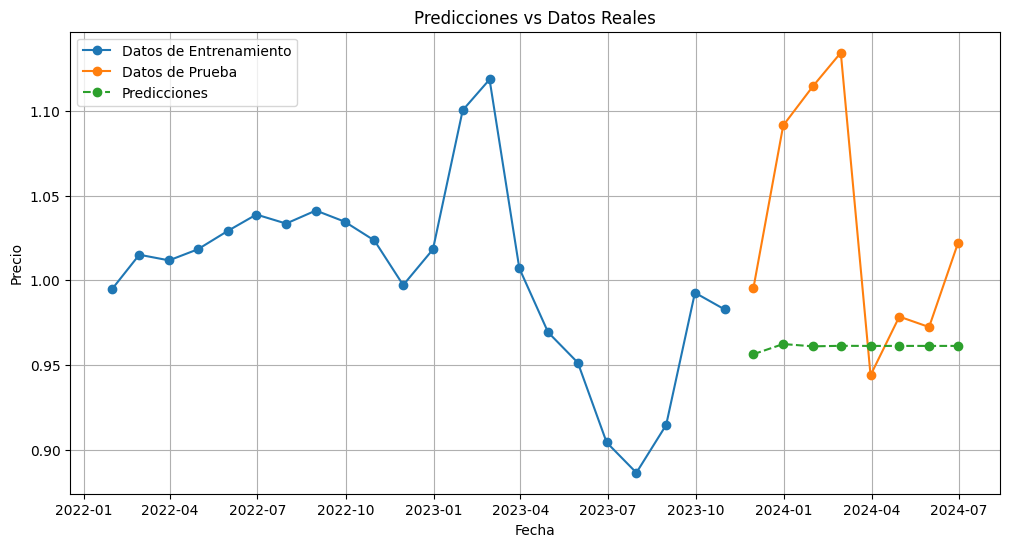

In [40]:
# 19.Visualización de resultados
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data, label='Datos de Entrenamiento', marker='o', linestyle='-')
plt.plot(test_data.index, test_data, label='Datos de Prueba', marker='o', linestyle='-')
plt.plot(test_data.index, predictions, label='Predicciones', marker='o', linestyle='--')
plt.title('Predicciones vs Datos Reales')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [41]:
# 20.Predicción para los próximos n pasos
n_steps = 6 # Por ejemplo, predicción para los próximos 6 meses
future_predictions = model_fit.forecast(steps=n_steps)

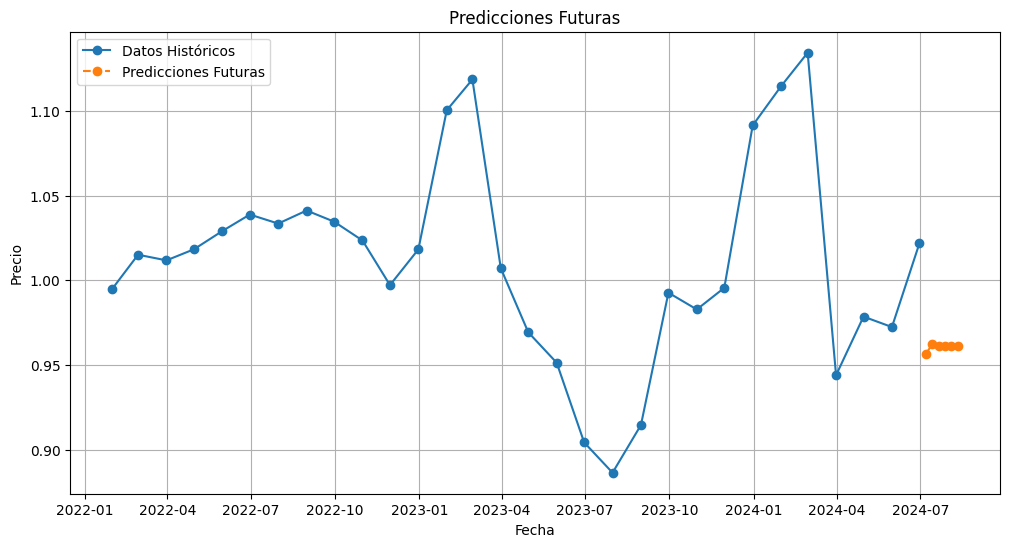

In [42]:
# 21. Visualización de predicciones futuras
plt.figure(figsize=(12, 6))
plt.plot(data_monthly['PRECIO'], label='Datos Históricos', marker='o', linestyle='-')
plt.plot(pd.date_range(start=data_monthly.index[-1], periods=n_steps+1, freq='W')[1:], future_predictions, label='Predicciones Futuras', marker='o', linestyle='--')
plt.title('Predicciones Futuras')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [43]:

# 22. Resumen del modelo
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 PRECIO   No. Observations:                   22
Model:                 ARIMA(1, 1, 1)   Log Likelihood                  40.470
Date:                Thu, 20 Jun 2024   AIC                            -74.939
Time:                        15:01:14   BIC                            -71.806
Sample:                    01-31-2022   HQIC                           -74.259
                         - 10-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2266      0.527     -0.430      0.667      -1.260       0.807
ma.L1          0.7616      0.291      2.617      0.009       0.191       1.332
sigma2         0.0012      0.000      3.379      0.0

In [44]:
# 23. Obtener los residuos
residuals = model_fit.resid

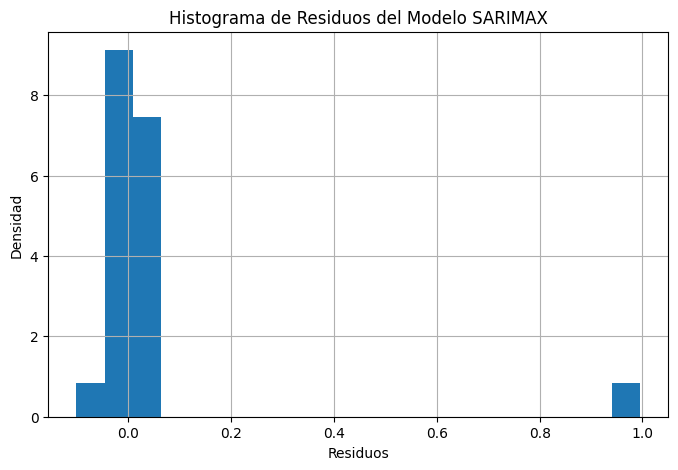

In [45]:
# 24. observar distribución de residuos
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, density=True)
plt.title('Histograma de Residuos del Modelo SARIMAX')
plt.xlabel('Residuos')
plt.ylabel('Densidad')
plt.grid(True)
plt.show()

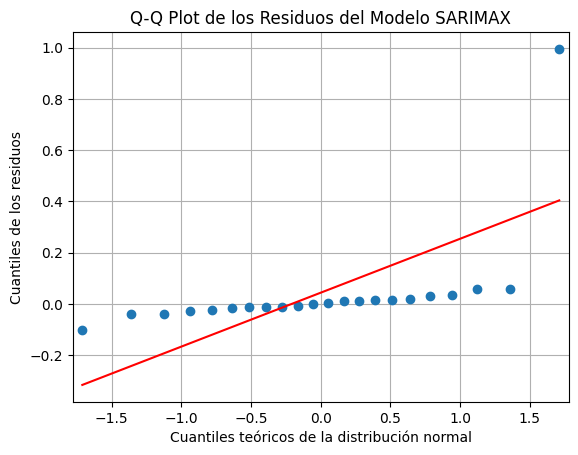

In [46]:
# Q-Q plot de los residuos
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot de los Residuos del Modelo SARIMAX')
plt.xlabel('Cuantiles teóricos de la distribución normal')
plt.ylabel('Cuantiles de los residuos')
plt.grid(True)
plt.show()

In [47]:
from scipy.stats import jarque_bera

_, p_value = jarque_bera(residuals)
print(f'p-value de Jarque-Bera: {p_value}')

p-value de Jarque-Bera: 1.0508594344333689e-65


In [48]:
#Definir MAPE
def mean_absolute_percentage_error(y_true, y_pred):

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(test_data, predictions)
print(f'Error absoluto porcentual medio (MAPE): {mape:.2f}%')


Error absoluto porcentual medio (MAPE): 6.93%
